In [60]:
import re
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from collections import Counter, OrderedDict
from wordcloud import WordCloud

# **Load Data**

In [61]:
df = pd.read_csv('data.csv',encoding='latin-1')

alay_dict = pd.read_csv('new_kamusalay.csv', names = ['original', 'replacement'], encoding='latin-1')

abusive_dict = pd.read_csv('abusive.csv', encoding='latin-1')

stopword_dict = pd.read_csv('stopwordbahasa.csv', names = ['stopword'], encoding='latin-1')

In [62]:
df.dropna(how="any", inplace=True, axis=1)
df = df[['Tweet', 'HS', 'Abusive']]
df.columns = ['Tweet', 'HS', 'Abusive']

df = df.copy()
df.head()

,Tweet,HS,Abusive
0,- disaat semua cowok berusaha melacak perhatia...,1,1
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1


# **Data Cleaning**

In [63]:
def lowercase(text):
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('\\+n', ' ', text)
    text = re.sub('\n'," ",text)
    text = re.sub('rt',' ',text)
    text = re.sub('RT',' ',text)
    text = re.sub('user',' ',text)
    text = re.sub('USER', ' ', text)
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text)
    text = re.sub(':', ' ', text)
    text = re.sub(';', ' ', text)
    text = re.sub('\\+n', ' ', text)
    text = re.sub('\n'," ",text)
    text = re.sub('\\+', ' ', text)
    text = re.sub('  +', ' ', text)
    return text

def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text)
    return text

alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))
def normalize_alay(text):
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])


def remove_stopword(text):
    text = ' '.join(['' if word in stopword_dict.stopword.values else word for word in text.split(' ')])
    text = re.sub('  +', ' ', text)
    text = text.strip()
    return text

def remove_emoticon_byte(text):
    text = text.replace("\\", " ")
    text = re.sub('x..', ' ', text)
    text = re.sub(' n ', ' ', text)
    text = re.sub('\\+', ' ', text)
    text = re.sub('  +', ' ', text)
    return text

def remove_early_space(text):
    if text[0] == ' ':
        return text[1:]
    else:
        return text

<>:11: SyntaxWarning: invalid escape sequence '\.'
<>:11: SyntaxWarning: invalid escape sequence '\.'
C:\Users\qolbi\AppData\Local\Temp\ipykernel_25712\220286023.py:11: SyntaxWarning: invalid escape sequence '\.'
  text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text)


## **Data Processing**

In [64]:
def preprocess(text):
    text = lowercase(text)
    text = remove_nonaplhanumeric(text)
    text = remove_unnecessary_char(text)
    text = normalize_alay(text)
    text = remove_stopword(text)
    return text

In [65]:
df['Tweet'] = df['Tweet'].apply(preprocess)
df.head(10)

,Tweet,HS,Abusive
0,cowok berusaha melacak perhatian gue lantas re...,1,1
1,telat tau edan sarap gue bergaul cigax jifla c...,0,1
2,41 kadang berpikir percaya tuhan jatuh berkali...,0,0
3,ku tau matamu sipit,0,0
4,kaum cebong kafir dongoknya dungu haha,1,1
5,ya bani taplak kawan kawan xf0 x9f x98 x84 xf0...,1,1
6,deklarasi pilihan kepala daerah 2018 aman anti...,0,0
7,gue selesai re watch aldnoah zero kampret 2 ka...,0,1
8,admin belanja po terbaik nak makan ais kepal m...,0,0
9,enak ngewe,0,1


# EDA

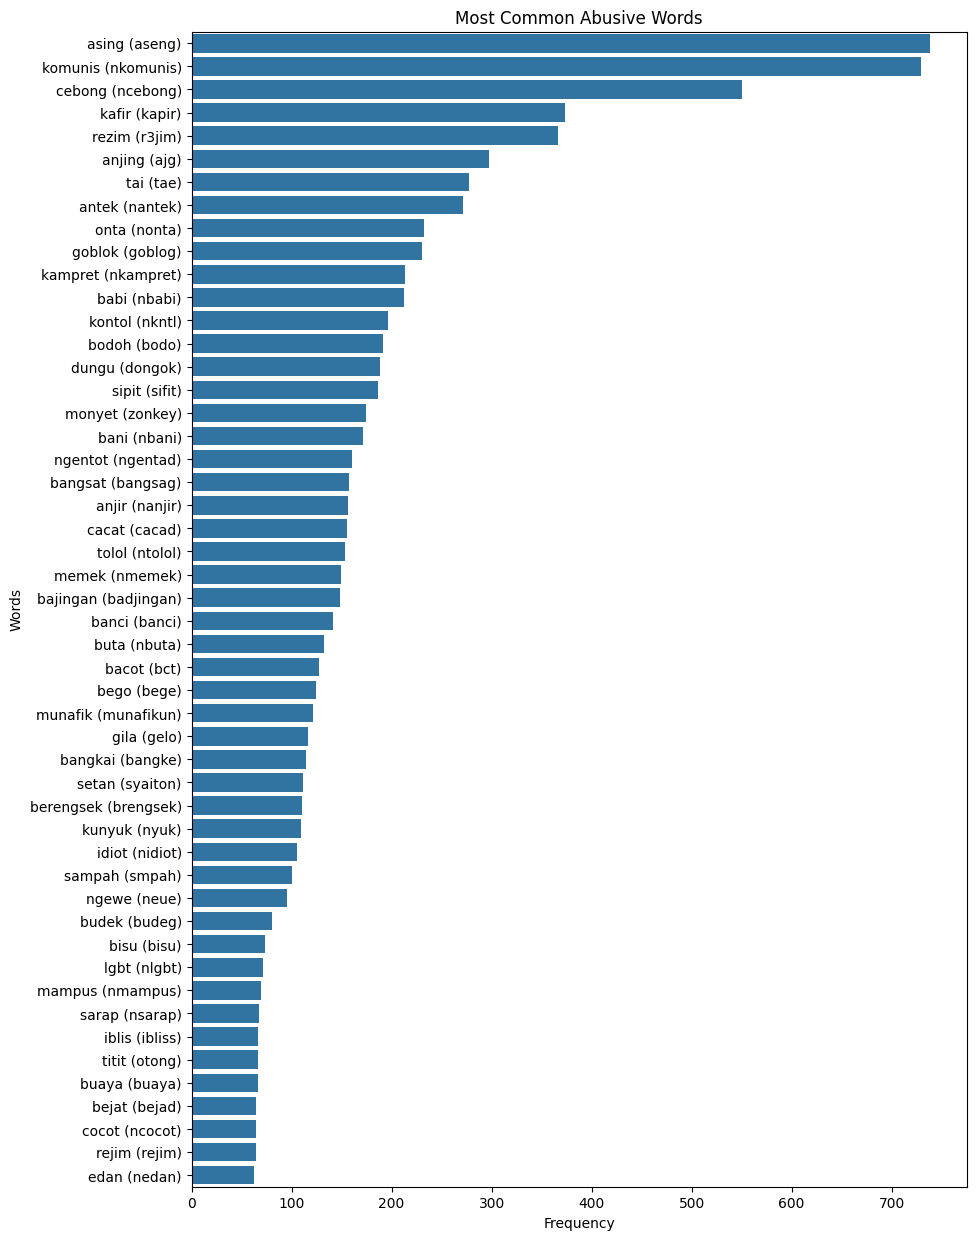

In [66]:
tweets_corpus = []

# Populate the tweets_corpus list
for tweet in df['Tweet'].str.split():
    for word in tweet:
        if len(word) > 0 and word in abusive_dict.values:
            tweets_corpus.append(word)

# Count the occurrences of each word
counter_tweets = Counter(tweets_corpus).most_common()[:1000]
top_tweets = OrderedDict(counter_tweets)

show_only = 50

keys = list(top_tweets.keys())
vals = [top_tweets[k] for k in keys]

# Map original slang words
original_slang = []
for word in keys:
    if word in alay_dict['replacement'].values:
        original_slang.append(alay_dict.loc[alay_dict['replacement'] == word, 'original'].values[0])
    else:
        original_slang.append(word)

combined_words = [f'{keys[i]} ({original_slang[i]})' for i in range(len(keys))]

# Plotting the bar chart
plt.figure(figsize=(10, 15))
sns.barplot(x=vals[:show_only], y=combined_words[:show_only])
plt.title('Most Common Abusive Words')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()


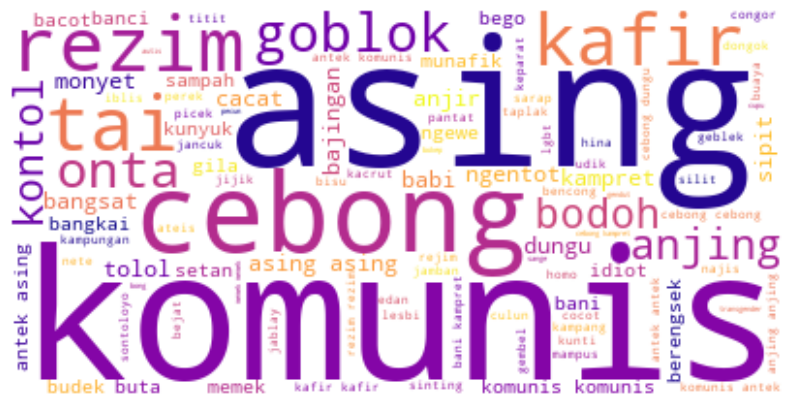

In [67]:
fig, axes = plt.subplots(ncols=1, figsize=(10, 8))
tokens_ = ' '.join(tweets_corpus)
wc_ = WordCloud(max_words=100, background_color='white', max_font_size=100, colormap='plasma').generate(tokens_)
axes.axis("off")
axes.imshow(wc_, interpolation="bilinear")
plt.show()

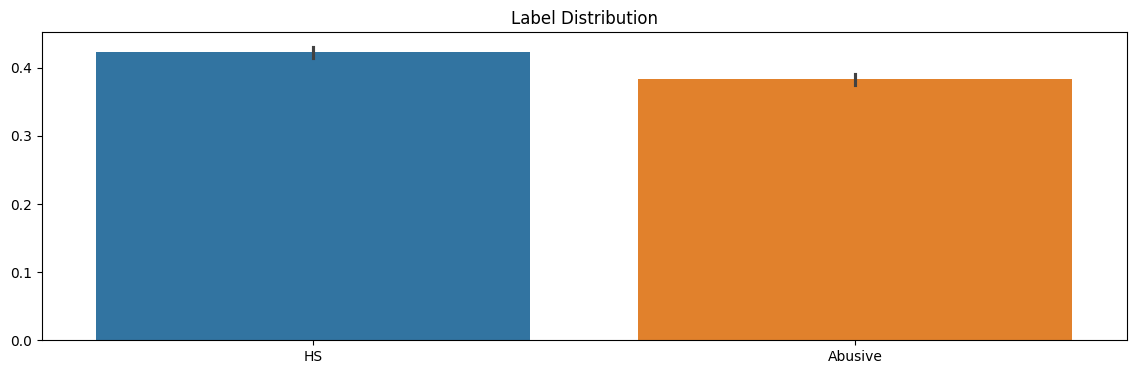

In [68]:
plt.figure(figsize=(14,4))
plt.title('Label Distribution')
sns.barplot(df)
plt.show()

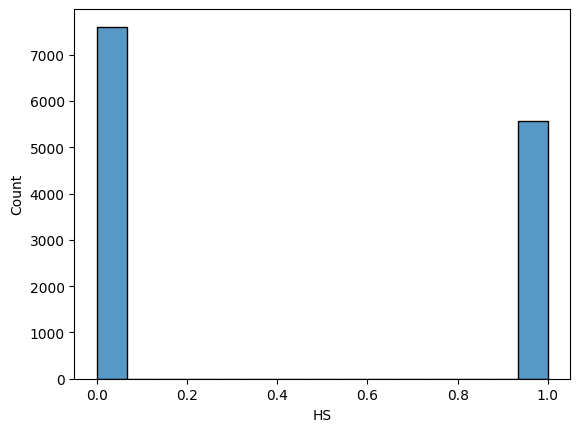

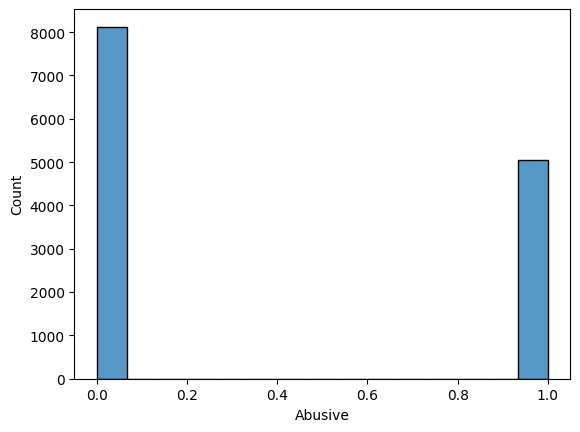

In [69]:
df1 = df.drop(['Tweet'], axis=1)
for i in df1.columns:
    j = 1
    plt.figure(j)
    sns.histplot(data=df1, x=i)
    plt.show()
    j = j+1

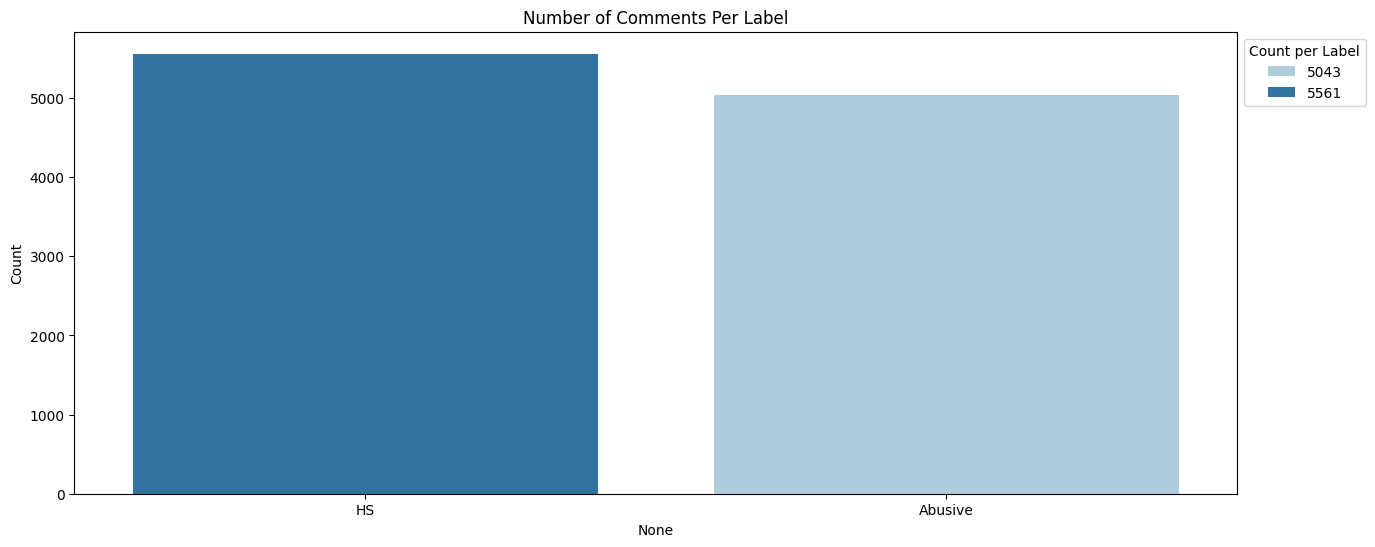

In [70]:
df2 = df1.sum()
plt.figure(figsize=(15, 6))
sns.barplot(x=df2.index, y=df2.values, hue=df2.values, dodge=False, palette='Paired')
plt.ylabel('Count')
plt.title("Number of Comments Per Label")
leg = plt.legend(title='Count per Label', bbox_to_anchor=(1,1))

# Split Data

In [71]:
df.head(10)

,Tweet,HS,Abusive
0,cowok berusaha melacak perhatian gue lantas re...,1,1
1,telat tau edan sarap gue bergaul cigax jifla c...,0,1
2,41 kadang berpikir percaya tuhan jatuh berkali...,0,0
3,ku tau matamu sipit,0,0
4,kaum cebong kafir dongoknya dungu haha,1,1
5,ya bani taplak kawan kawan xf0 x9f x98 x84 xf0...,1,1
6,deklarasi pilihan kepala daerah 2018 aman anti...,0,0
7,gue selesai re watch aldnoah zero kampret 2 ka...,0,1
8,admin belanja po terbaik nak makan ais kepal m...,0,0
9,enak ngewe,0,1


In [72]:
from sklearn.model_selection import train_test_split
# Define the features (X) and the target variable (y)
X = df['Tweet']
y = df[['HS','Abusive']]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shape of the split datasets
print('Training set shape:', X_train.shape, y_train.shape)
print('Testing set shape:', X_test.shape, y_test.shape)

Training set shape: (10535,) (10535, 2)
Testing set shape: (2634,) (2634, 2)


In [73]:
X_train.to_pickle('X_train.pkl')
X_test.to_pickle('X_test.pkl')
y_train.to_pickle('y_train.pkl')
y_test.to_pickle('y_test.pkl')

In [74]:
X_train = pd.read_pickle('X_train.pkl')
X_test = pd.read_pickle('X_test.pkl')
y_train = pd.read_pickle('y_train.pkl')
y_test = pd.read_pickle('y_test.pkl')

## **Model Training**

In [75]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.utils import to_categorical

In [76]:
# Tokenize the text data
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train_tokens = tokenizer.texts_to_sequences(X_train)
X_test_tokens = tokenizer.texts_to_sequences(X_test)

maxlen = 100
X_train_pad = pad_sequences(X_train_tokens, maxlen=maxlen)
X_test_pad = pad_sequences(X_test_tokens, maxlen=maxlen)

model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=100, input_length=maxlen))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'Precision', 'Recall'])
print(model.summary())
# Train the model
history = model.fit(X_train_pad, y_train, epochs=25, batch_size=64, validation_split=0.2, verbose=1)

# Evaluate the model on the test set
score = model.evaluate(X_test_pad, y_test, verbose=1)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

c:\Users\qolbi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ ?                      │   0 (unbuilt) │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/25
132/132 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - Precision: 0.5939 - Recall: 0.2038 - accuracy: 0.6411 - loss: 0.6315 - val_Precision: 0.7373 - val_Recall: 0.8390 - val_accuracy: 0.7238 - val_loss: 0.4124
Epoch 2/25
132/132 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - Precision: 0.8299 - Recall: 0.8352 - accuracy: 0.7114 - loss: 0.3259 - val_Precision: 0.8404 - val_Recall: 0.8298 - val_accuracy: 0.7295 - val_loss: 0.3198
Epoch 3/25
132/132 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - Precision: 0.8947 - Recall: 0.8867 - accuracy: 0.7022 - loss: 0.2267 - val_Precision: 0.8531 - val_Recall: 0.8211 - val_accuracy: 0.7318 - val_loss: 0.3147
Epoch 4/25
132/132 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - Precision: 0.9190 - Recall: 0.9122 - accuracy: 0.7274 - loss: 0.1760 - val_Precision: 0.8650 - val_Recall: 0.8027 - val_accuracy: 0.7062 - val_loss: 0.3335
Epoch 5/25
132/132 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - Precision: 0.9294 - Recall: 0.9298 - accuracy: 0.7100 - loss: 0.1578 - val_Precision: 0.8536 - v

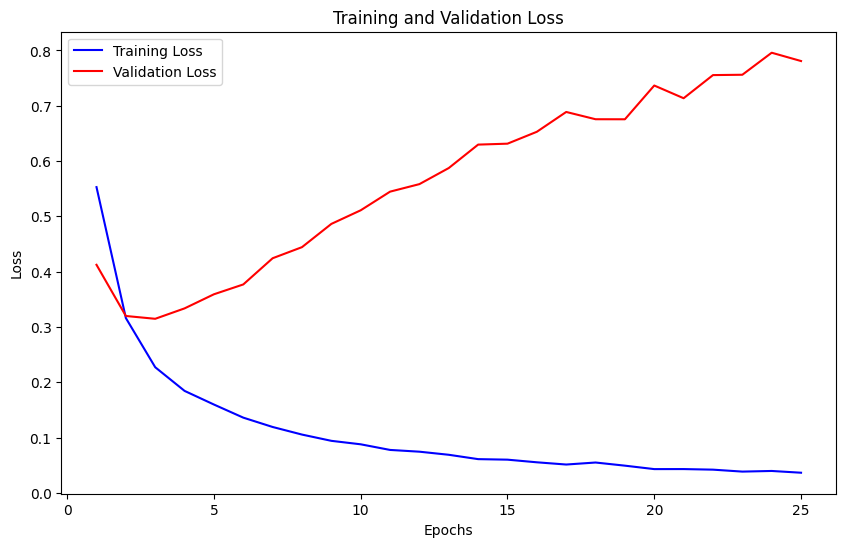

In [77]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [78]:
model.save('model.h5')

# **Tuning Model**

In [79]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report

In [80]:
if isinstance(y_train, pd.DataFrame) or isinstance(y_train, np.ndarray):
    y_train = np.argmax(y_train.values, axis=1) if isinstance(y_train, pd.DataFrame) else np.argmax(y_train, axis=1)
if isinstance(y_test, pd.DataFrame) or isinstance(y_test, np.ndarray):
    y_test = np.argmax(y_test.values, axis=1) if isinstance(y_test, pd.DataFrame) else np.argmax(y_test, axis=1)

In [81]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('clf', LogisticRegression(max_iter=1000))
])

In [82]:
param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'clf__C': [0.1, 1, 10]
}

In [83]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(stop_words='english')),
                                       ('clf',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.1, 1, 10],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             scoring='accuracy')

## **Model Evaluation**

In [84]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

In [90]:
# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Calculate Accuracy, Precision, and Recall
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Print the evaluation metrics
print(f'Test Accuracy: {accuracy}')
print(f'Test Precision: {precision}')
print(f'Test Recall: {recall}')
print("Best Parameters:", grid_search.best_params_)
print("Classification Report:\n", classification_report(y_test, y_pred))

Test Accuracy: 0.911921032649962
Test Precision: 0.7154150197628458
Test Recall: 0.530791788856305
Best Parameters: {'clf__C': 10, 'tfidf__ngram_range': (1, 2)}
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95      2293
           1       0.72      0.53      0.61       341

    accuracy                           0.91      2634
   macro avg       0.82      0.75      0.78      2634
weighted avg       0.90      0.91      0.91      2634



In [ ]:
# Save the model if needed
import joblib
joblib.dump(best_model, 'best_model.pkl')

['best_model.pkl']

# Conclusion

1. **Test Accuracy: 0.911921032649962:**

Akurasi (Accuracy): model memprediksi dengan benar 91.19% dari seluruh data test.

2. **Test Precision: 0.7154150197628458:**

Presisi (Precision): dari semua prediksi positif, 71.54% adalah benar.

3. **Test Recall: 0.530791788856305:**

Recall: model hanya berhasil mendeteksi 53.08% dari mereka.

**Secara keseluruhan, model yang dibuat memiliki akurasi yang tinggi (91%), namun presisi dan recallnya tergolong rendah**